In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

In [6]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA


In [7]:
# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]

# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)

# Parâmetros adicionais
n = 14
d = 10
t = 14
# Lista de parâmetros n para iterar
e_list = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]  # Exemplo de diferentes valores de n
alpha = 0.20  # Mantemos um único valor de alpha


price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target_verify(x, d)
)

# Loop para calcular e salvar a variável para cada valor de 'e'
for e in e_list:
    # Calcula o Price Rate of Change para o valor atual de 'e'
    price_data[f'Price_Rate_Of_Change_{e}'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
        lambda x: x.pct_change(periods=e)
    )

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)


# Criação das variáveis low_t e high_t
low_t, high_t = price_data[['Ticker', 'Low']].copy(), price_data[['Ticker', 'High']].copy()
# Cálculo dos valores mínimos e máximos baseados na janela t
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=t).max())

# Cálculo do k_percent
k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))


# Armazenando os resultados no DataFrame com nomes dinâmicos
price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent


# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)
price_data[f'r_percent_{t}'] = r_percent


# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)


# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Price_Rate_Of_Change_4,Price_Rate_Of_Change_5,Price_Rate_Of_Change_6,Price_Rate_Of_Change_7,Price_Rate_Of_Change_8,Price_Rate_Of_Change_9,Price_Rate_Of_Change_10,Price_Rate_Of_Change_11,Price_Rate_Of_Change_12,Price_Rate_Of_Change_13,down_days,up_days,RSI,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,On Balance Volume,Close_10
11769,2025-01-07,52.630001,52.889999,51.939999,52.049999,52.049999,22070200,VALE3.SA,-0.510002,53.789519,-1.0,-0.025124,-0.027881,-0.030475,-0.032525,-0.035768,-0.040775,-0.050536,-0.058194,-0.062311,-0.068538,0.510002,0.000000,19.428651,52.049999,1.0,51.939999,56.709999,38.773998,-61.226002,-1.241400,-1.059461,2096469370,54.020000
11770,2025-01-08,52.029999,52.290001,51.430000,51.549999,51.549999,24423800,VALE3.SA,-0.500000,53.341615,-1.0,-0.029987,-0.033242,-0.035976,-0.038548,-0.040581,-0.043797,-0.048762,-0.058442,-0.066036,-0.070119,0.500000,0.000000,17.253360,51.549999,1.0,51.430000,56.540001,37.409278,-62.590722,-1.310330,-1.109635,2072045570,52.660000
11771,2025-01-09,52.049999,52.250000,51.139999,51.230000,51.230000,15865200,VALE3.SA,-0.320000,52.919292,1.0,-0.031501,-0.037667,-0.040896,-0.043608,-0.046160,-0.048177,-0.051367,-0.056294,-0.065897,-0.073431,0.320000,0.000000,15.935783,51.230000,1.0,51.139999,56.400002,33.826835,-66.173165,-1.383093,-1.164327,2056180370,52.320000
11772,2025-01-10,51.540001,52.310001,51.230000,51.520000,51.520000,25833900,VALE3.SA,0.290001,52.639433,1.0,-0.029230,-0.036622,-0.042756,-0.045968,-0.048666,-0.051205,-0.053211,-0.056384,-0.061284,-0.070837,0.000000,0.290001,22.152280,51.520000,1.0,51.139999,55.869999,31.700511,-68.299489,-1.446663,-1.220794,2030346470,53.029999
11773,2025-01-13,52.000000,52.310001,50.869999,51.509998,51.509998,30845300,VALE3.SA,-0.010002,52.413546,1.0,-0.025581,-0.033396,-0.040756,-0.046864,-0.050062,-0.052748,-0.055276,-0.057274,-0.060433,-0.065312,0.010002,0.000000,22.087279,51.509998,1.0,50.869999,55.400002,34.073876,-65.926124,-1.498003,-1.276236,1999501170,52.910000


In [8]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Price_Rate_Of_Change_4,Price_Rate_Of_Change_5,Price_Rate_Of_Change_6,Price_Rate_Of_Change_7,Price_Rate_Of_Change_8,Price_Rate_Of_Change_9,Price_Rate_Of_Change_10,Price_Rate_Of_Change_11,Price_Rate_Of_Change_12,Price_Rate_Of_Change_13,down_days,up_days,RSI,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,On Balance Volume,Close_10
5736,2025-01-07,11.30,11.58,11.27,11.54,11.54,34905200,ABEV3.SA,0.25,11.827934,-1.0,-0.045460,-0.057840,-0.066835,-0.076580,-0.087072,-0.099686,-0.105770,-0.113593,-0.117622,-0.126817,0.00,0.25,28.541568,11.54,-1.0,11.21,13.42,27.960811,-72.039189,-0.264467,-0.095991,-2692457147,11.25
5737,2025-01-08,11.48,11.53,11.28,11.42,11.42,39248800,ABEV3.SA,-0.12,11.746347,-1.0,-0.039782,-0.052045,-0.064338,-0.073272,-0.082950,-0.093370,-0.105896,-0.111938,-0.119708,-0.123708,0.12,0.00,26.129481,11.42,-1.0,11.21,13.42,24.269101,-75.730899,-0.302041,-0.137201,-2731705947,11.02
5738,2025-01-09,11.43,11.51,11.30,11.40,11.40,24470100,ABEV3.SA,-0.02,11.677078,-1.0,-0.031141,-0.045444,-0.057635,-0.069856,-0.078737,-0.088358,-0.098716,-0.111168,-0.117175,-0.124899,0.02,0.00,25.711601,11.40,-1.0,11.21,13.19,23.589785,-76.410215,-0.333563,-0.176474,-2756176047,11.05
5739,2025-01-10,11.40,11.43,11.08,11.16,11.16,31277300,ABEV3.SA,-0.24,11.573662,-1.0,-0.027417,-0.039721,-0.053898,-0.065981,-0.078094,-0.086896,-0.096432,-0.106698,-0.119040,-0.124994,0.24,0.00,21.050384,11.16,-1.0,11.08,13.08,24.683109,-75.316891,-0.362708,-0.213721,-2787453347,10.87
5740,2025-01-13,11.18,11.31,11.12,11.24,11.24,28945300,ABEV3.SA,0.08,11.506930,-1.0,-0.027140,-0.033024,-0.045258,-0.059353,-0.071366,-0.083409,-0.092160,-0.101641,-0.111849,-0.124120,0.00,0.08,26.196436,11.24,-1.0,11.08,12.91,23.329494,-76.670506,-0.386733,-0.248323,-2816398647,10.91


e: 4
Fold 1:
 - Correct Prediction (y_test): 53.04%
 - Correct Prediction (Verify): 49.48%
Fold 2:
 - Correct Prediction (y_test): 57.23%
 - Correct Prediction (Verify): 54.82%
Fold 3:
 - Correct Prediction (y_test): 56.60%
 - Correct Prediction (Verify): 43.19%
Fold 4:
 - Correct Prediction (y_test): 56.39%
 - Correct Prediction (Verify): 50.31%
Fold 5:
 - Correct Prediction (y_test): 59.64%
 - Correct Prediction (Verify): 51.05%
Média de acurácia (y_test) para e 4: 56.58%
Média de acurácia (Verify) para e 4: 49.77%
---
e: 5
Fold 1:
 - Correct Prediction (y_test): 50.00%
 - Correct Prediction (Verify): 49.79%
Fold 2:
 - Correct Prediction (y_test): 55.03%
 - Correct Prediction (Verify): 53.25%
Fold 3:
 - Correct Prediction (y_test): 58.07%
 - Correct Prediction (Verify): 45.07%
Fold 4:
 - Correct Prediction (y_test): 56.92%
 - Correct Prediction (Verify): 52.10%
Fold 5:
 - Correct Prediction (y_test): 56.92%
 - Correct Prediction (Verify): 48.74%
Média de acurácia (y_test) para e 5: 5

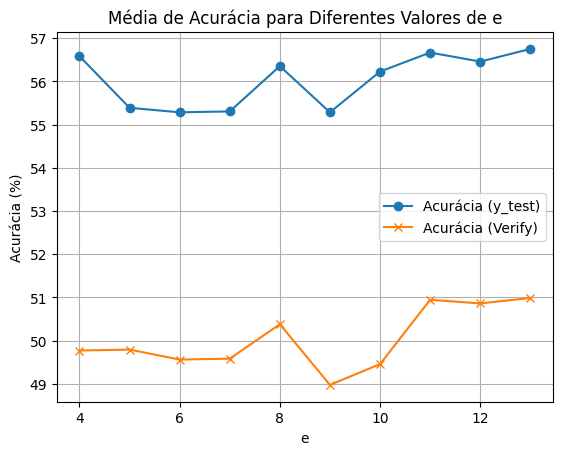

In [9]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por e
mean_accuracy_by_e = []

# Loop para cada e em n_list e realização de validação cruzada em série temporal
for e in e_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    'k_percent_14',
                    'r_percent_14',
                    f'Price_Rate_Of_Change_{e}',
                    'MACD',
                    'MACD_EMA',
                    'On Balance Volume']]
    y = price_data['Prediction']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse e
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'e: {e}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por e
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_e.append((e, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para e {e}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para e {e}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for e, acc_ytest, acc_verify in mean_accuracy_by_e:
    print(f'e: {e} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por e
import matplotlib.pyplot as plt

e_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_e)

plt.plot(e_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(e_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de e")
plt.xlabel('e')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
